In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/drug-classification/drug200.csv


In [2]:
## visualization
import seaborn as sns
import matplotlib.pyplot as plt

## preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer

## model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

## pipeline
from sklearn.pipeline import Pipeline

import random

seed = random.seed(100)

## Loading Dataset and Basic Analysis

In [3]:
path = '../input/drug-classification/drug200.csv'
dataLoad = pd.read_csv(path)
dataLoad.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY


In [4]:
dataLoad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    object 
 2   BP           200 non-null    object 
 3   Cholesterol  200 non-null    object 
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB


In [5]:
dataLoad.describe()

,Age,Na_to_K
count,200.000000,200.000000
mean,44.315000,16.084485
std,16.544315,7.223956
min,15.000000,6.269000
25%,31.000000,10.445500
50%,45.000000,13.936500
75%,58.000000,19.380000
max,74.000000,38.247000


In [6]:
dataLoad.isnull().sum()

Age            0
Sex            0
BP             0
Cholesterol    0
Na_to_K        0
Drug           0
dtype: int64

## Preprocessing

In [7]:
dataCopy = dataLoad.copy()
target = dataCopy['Drug']
features = dataCopy.drop('Drug', axis=1)
features.head()

,Age,Sex,BP,Cholesterol,Na_to_K
0,23,F,HIGH,HIGH,25.355
1,47,M,LOW,HIGH,13.093
2,47,M,LOW,HIGH,10.114
3,28,F,NORMAL,HIGH,7.798
4,61,F,LOW,HIGH,18.043


In [8]:
OH_cols=[]
for i in features.columns:
    if features[i].nunique() < 5 :
        OH_cols.append(i)
        

encoder = OneHotEncoder()
encodedData = encoder.fit_transform(features[OH_cols]).toarray()
encodedLabel = encoder.categories_

featLabel = []
for j in range(3):
    for k in range(len(encodedLabel[j])):
        label = encodedLabel[j][k]
        featLabel.append(label)

encoded_df = pd.DataFrame(encodedData, columns=featLabel)
encoded_df.head()

,F,M,HIGH,LOW,NORMAL,HIGH,NORMAL
0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,1.0,0.0,0.0,0.0,1.0,1.0,0.0
4,1.0,0.0,0.0,1.0,0.0,1.0,0.0


In [9]:
df_features = pd.concat([features['Age'], features['Na_to_K'], encoded_df], axis=1)
df_features.head()

,Age,Na_to_K,F,M,HIGH,LOW,NORMAL,HIGH,NORMAL
0,23,25.355,1.0,0.0,1.0,0.0,0.0,1.0,0.0
1,47,13.093,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,47,10.114,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,28,7.798,1.0,0.0,0.0,0.0,1.0,1.0,0.0
4,61,18.043,1.0,0.0,0.0,1.0,0.0,1.0,0.0


In [10]:
labelenc = LabelEncoder()
targetEncoded = pd.DataFrame(labelenc.fit_transform(target), columns=['Drug'])
targetEncoded.head()

,Drug
0,0
1,3
2,3
3,4
4,0


In [11]:
x_train, x_test, y_train, y_test = train_test_split(df_features, targetEncoded, test_size=0.2)
X_train, X_valid, Y_train, Y_valid = train_test_split(x_train, y_train, test_size=0.2)
print(X_train.shape , X_valid.shape)
print(Y_train.shape, Y_valid.shape)

(128, 9) (32, 9)
(128, 1) (32, 1)


In [12]:
scaler= MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.fit_transform(X_valid)

X_train.shape , X_valid.shape

((128, 9), (32, 9))

## Baseline Model

In [13]:
modelBl= KNeighborsClassifier()
modelBl.fit(X_train, Y_train.values.ravel())
predBl = modelBl.predict(X_valid)
print(accuracy_score(Y_valid.values.ravel(), predBl))

0.6875


In [14]:
print(classification_report(Y_valid.values.ravel(), predBl))

              precision    recall  f1-score   support

           0       0.62      0.62      0.62        13
           1       0.50      1.00      0.67         3
           2       0.00      0.00      0.00         0
           3       1.00      0.50      0.67         4
           4       0.90      0.75      0.82        12

    accuracy                           0.69        32
   macro avg       0.60      0.57      0.55        32
weighted avg       0.76      0.69      0.70        32



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


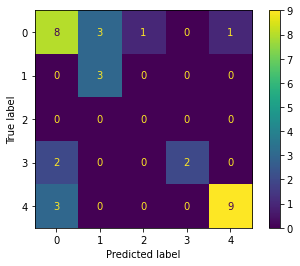

In [15]:
cmBl = confusion_matrix(Y_valid.values.ravel(), predBl)
ConfusionMatrixDisplay(cmBl).plot()

In [16]:
Y_valid.value_counts()

Drug
0       13
4       12
3        4
1        3
dtype: int64

## Exploratory Data Analysis

<AxesSubplot:ylabel='Drug'>

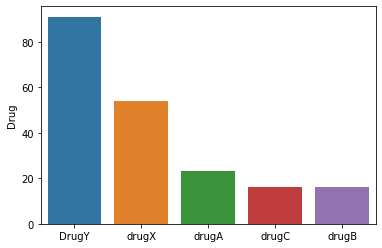

In [17]:
drug = target.value_counts()
sns.barplot(y=drug, x=drug.index)

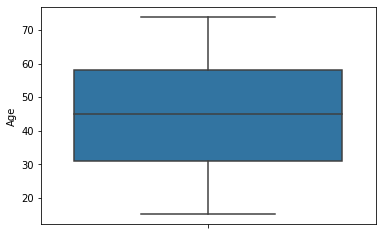

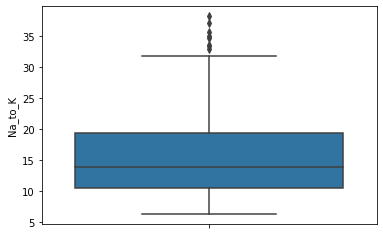

In [18]:
cols = ['Age', 'Na_to_K']

for col in cols:
    sns.boxplot(y = col, data=dataCopy)
    plt.show()

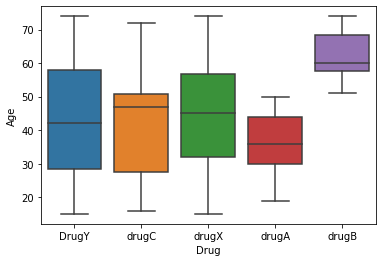

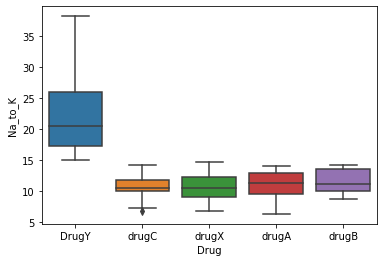

In [19]:
for u in cols:
    sns.boxplot(x = 'Drug', y = u, data=dataCopy)
    plt.show()

## Removing Outliers

The next step we remove an outliers from the data. It because KNN model is very sensitive with outliers.

In [20]:
## removing outliers on Na_to_K variable

Q1 = dataCopy['Na_to_K'].quantile(0.25)
Q3 = dataCopy['Na_to_K'].quantile(0.75)

IQR = Q3 - Q1

for i in range(len(dataCopy['Na_to_K'])):
    if dataCopy['Na_to_K'][i] < (Q1-IQR*1.5) or dataCopy['Na_to_K'][i] > (Q3 + IQR*1.5):
        dataCopy['Na_to_K'][i] = np.nan
    else:
        continue

dataCopy['Na_to_K'].isnull().sum()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


8

In [21]:
## Imputing nan value with mean
imputer = SimpleImputer(strategy='mean')

naClean = pd.DataFrame(imputer.fit_transform(dataCopy[['Na_to_K']]), columns=['Na_to_K'])
naClean.isnull().sum()

Na_to_K    0
dtype: int64

In [22]:
df_feature= df_features.drop('Na_to_K', axis=1)
df_feature.head()

,Age,F,M,HIGH,LOW,NORMAL,HIGH,NORMAL
0,23,1.0,0.0,1.0,0.0,0.0,1.0,0.0
1,47,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,47,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,28,1.0,0.0,0.0,0.0,1.0,1.0,0.0
4,61,1.0,0.0,0.0,1.0,0.0,1.0,0.0


In [23]:
naClean.index = df_feature.index

df_Feature =pd.concat([df_feature, naClean], axis=1)
df_Feature.head()

,Age,F,M,HIGH,LOW,NORMAL,HIGH,NORMAL,Na_to_K
0,23,1.0,0.0,1.0,0.0,0.0,1.0,0.0,25.355
1,47,0.0,1.0,0.0,1.0,0.0,1.0,0.0,13.093
2,47,0.0,1.0,0.0,1.0,0.0,1.0,0.0,10.114
3,28,1.0,0.0,0.0,0.0,1.0,1.0,0.0,7.798
4,61,1.0,0.0,0.0,1.0,0.0,1.0,0.0,18.043


In [24]:
x_train, x_test, y_train, y_test = train_test_split(df_Feature, targetEncoded, test_size=0.2)
X_train, X_valid, Y_train, Y_valid = train_test_split(x_train, y_train, test_size=0.2)
print(X_train.shape , X_valid.shape)
print(Y_train.shape, Y_valid.shape)

(128, 9) (32, 9)
(128, 1) (32, 1)


In [25]:
scaler= MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.fit_transform(X_valid)

X_train.shape , X_valid.shape

((128, 9), (32, 9))

## Model Optimization

Then, we are trying to get optimum parameter for our KNN model. In this case I will try to search the most optimum k number. I did it with gridcv method

In [26]:
params ={'n_neighbors':[3, 5, 7, 9]}

model = KNeighborsClassifier()
knnGrid = GridSearchCV(model, params, cv=5)

knnGrid.fit(X_train, Y_train.values.ravel())

print(knnGrid.best_score_)
print(knnGrid.best_params_)

0.7581538461538461
{'n_neighbors': 3}


In [27]:
optmodel = KNeighborsClassifier(n_neighbors=3)
optmodel.fit(X_train, Y_train.values.ravel())
optpred = optmodel.predict(X_valid)
print(accuracy_score(Y_valid.values.ravel(), optpred))

0.75


In [28]:
print(classification_report(Y_valid.values.ravel(), optpred))

              precision    recall  f1-score   support

           0       0.75      0.86      0.80        14
           1       0.75      0.75      0.75         4
           2       0.75      0.75      0.75         4
           3       1.00      0.50      0.67         4
           4       0.67      0.67      0.67         6

    accuracy                           0.75        32
   macro avg       0.78      0.70      0.73        32
weighted avg       0.77      0.75      0.75        32



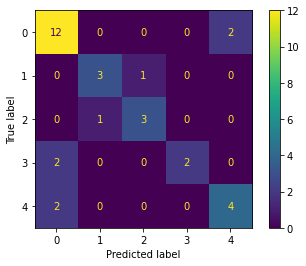

In [29]:
cmopt = confusion_matrix(Y_valid.values.ravel(), optpred)
cmviz = ConfusionMatrixDisplay(cmopt).plot()

## Making pipeline

In [30]:
my_pipeline = Pipeline(steps=[('scaler', MinMaxScaler()), ('model', optmodel)])

my_pipeline.fit(x_train, y_train.values.ravel())
pred = my_pipeline.predict(x_test)

print(accuracy_score(y_test.values.ravel(), pred))

0.75


In [31]:
print(classification_report(y_test.values.ravel(), pred))

              precision    recall  f1-score   support

           0       0.86      0.60      0.71        20
           1       0.71      1.00      0.83         5
           2       1.00      1.00      1.00         1
           3       0.62      1.00      0.77         5
           4       0.70      0.78      0.74         9

    accuracy                           0.75        40
   macro avg       0.78      0.88      0.81        40
weighted avg       0.78      0.75      0.74        40



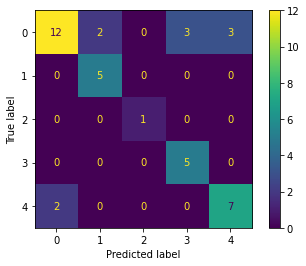

In [32]:
cm = confusion_matrix(y_test.values.ravel(), pred)
cmviz = ConfusionMatrixDisplay(cm).plot()